In [ ]:
!pip install transformers
from transformers import MaskFormerImageProcessor
import torch
from transformers import MaskFormerForInstanceSegmentation
import numpy as np
import cv2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import requests

url = "/content/img.jpeg"
image = Image.open(url)

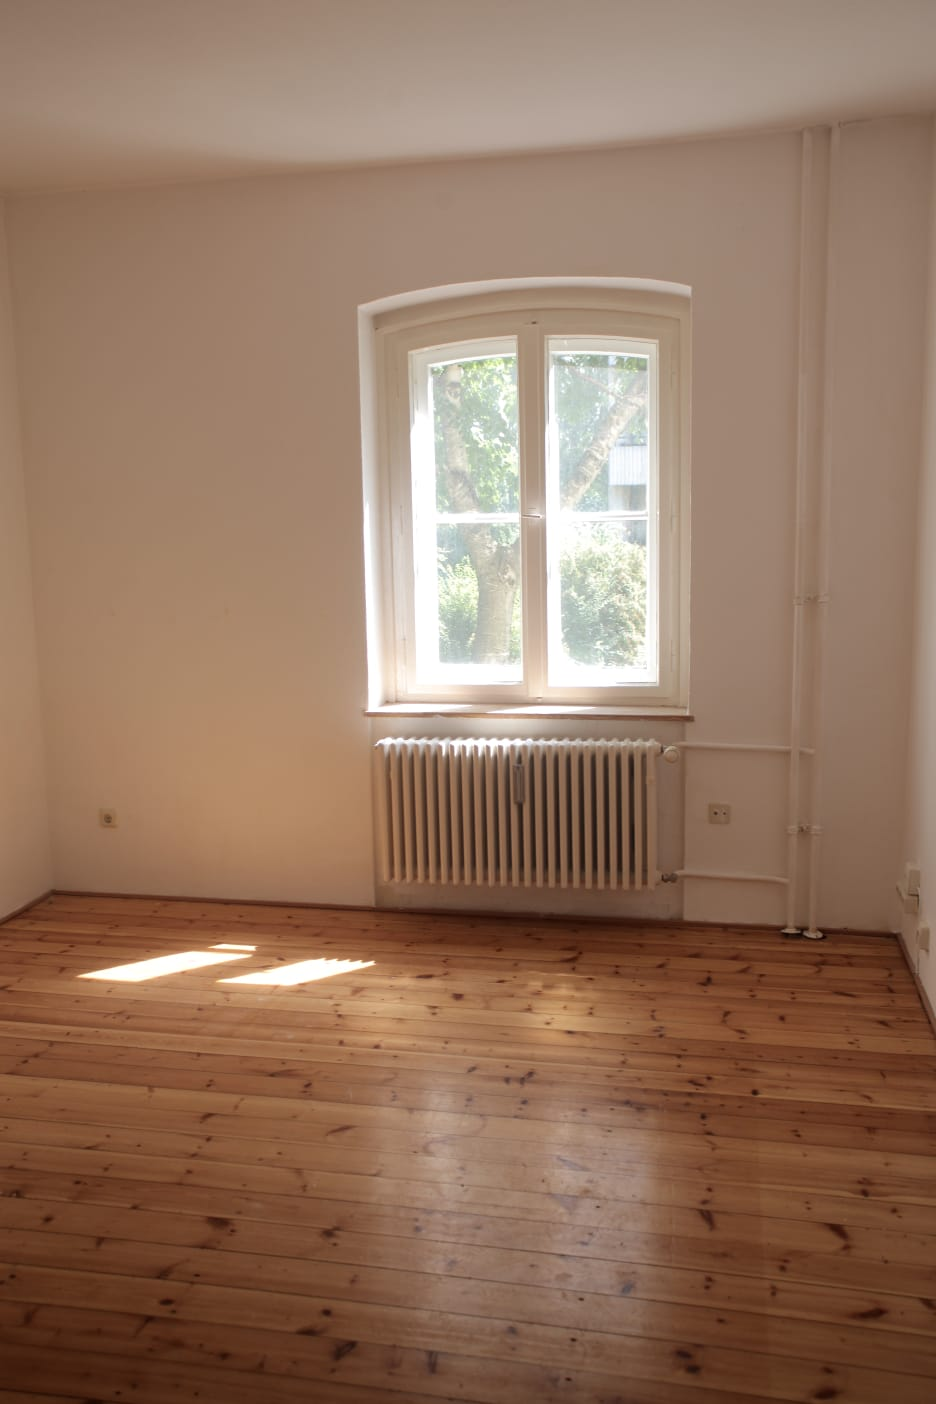

In [ ]:
image

In [ ]:
checkpoint_name = "facebook/maskformer-swin-small-coco"

processor = MaskFormerImageProcessor.from_pretrained(checkpoint_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:411: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:418: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [ ]:
inputs = processor(image, return_tensors="pt")
inputs.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
model = MaskFormerForInstanceSegmentation.from_pretrained(checkpoint_name)

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
print(outputs.keys())

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


In [ ]:
panoptic_segmentation = processor.post_process_panoptic_segmentation(outputs)[0]

`label_ids_to_fuse` unset. No instance will be fused.


In [ ]:
print(panoptic_segmentation['segments_info'])

[{'id': 1, 'label_id': 115, 'was_fused': False, 'score': 0.991109}, {'id': 2, 'label_id': 131, 'was_fused': False, 'score': 0.997931}, {'id': 3, 'label_id': 118, 'was_fused': False, 'score': 0.995165}, {'id': 4, 'label_id': 87, 'was_fused': False, 'score': 0.999441}]


In [ ]:
image_np = np.array(image,dtype=np.uint8)
image_np.shape

(1404, 936, 3)

In [ ]:
for segment in panoptic_segmentation['segments_info']:
  if segment['label_id'] == 115:
    window_mask = segment['id']
  elif segment['label_id'] == 131:
    wall_mask = segment['id']
  elif segment['label_id'] == 118:
    roof_mask = segment['id']
  elif segment['label_id'] == 87:
    floor_mask = segment['id']

mask_floor = (panoptic_segmentation['segmentation'].to("cpu").numpy() == floor_mask).astype(np.uint8)
mask_roof = (panoptic_segmentation['segmentation'].to("cpu").numpy() == roof_mask).astype(np.uint8)
mask_window = (panoptic_segmentation['segmentation'].to("cpu").numpy() == window_mask).astype(np.uint8)
mask_wall = (panoptic_segmentation['segmentation'].to("cpu").numpy() == wall_mask).astype(np.uint8)

mask_floor = np.array(mask_floor)
mask_roof = np.array(mask_roof)
mask_window = np.array(mask_window)
mask_wall = np.array(mask_wall)

mask_floor = cv2.resize(mask_floor, (image_np.shape[1], image_np.shape[0]))
mask_roof = cv2.resize(mask_roof, (image_np.shape[1], image_np.shape[0]))
mask_window = cv2.resize(mask_window, (image_np.shape[1], image_np.shape[0]))
mask_wall = cv2.resize(mask_wall, (image_np.shape[1], image_np.shape[0]))

segmented_image = cv2.bitwise_and(image_np,image_np,mask=mask_wall)


In [ ]:
floor_contours, _ = cv2.findContours(mask_floor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_floor_contour = max(floor_contours, key=cv2.contourArea)
contour_image_floor = image_np.copy()

cv2.drawContours(contour_image_floor, [largest_floor_contour], 0, (0, 255, 0), 2)
x, y, w, h = cv2.boundingRect(largest_floor_contour)
room_width = w
print("Width of the room:", room_width, "pixels")

Width of the room: 936 pixels


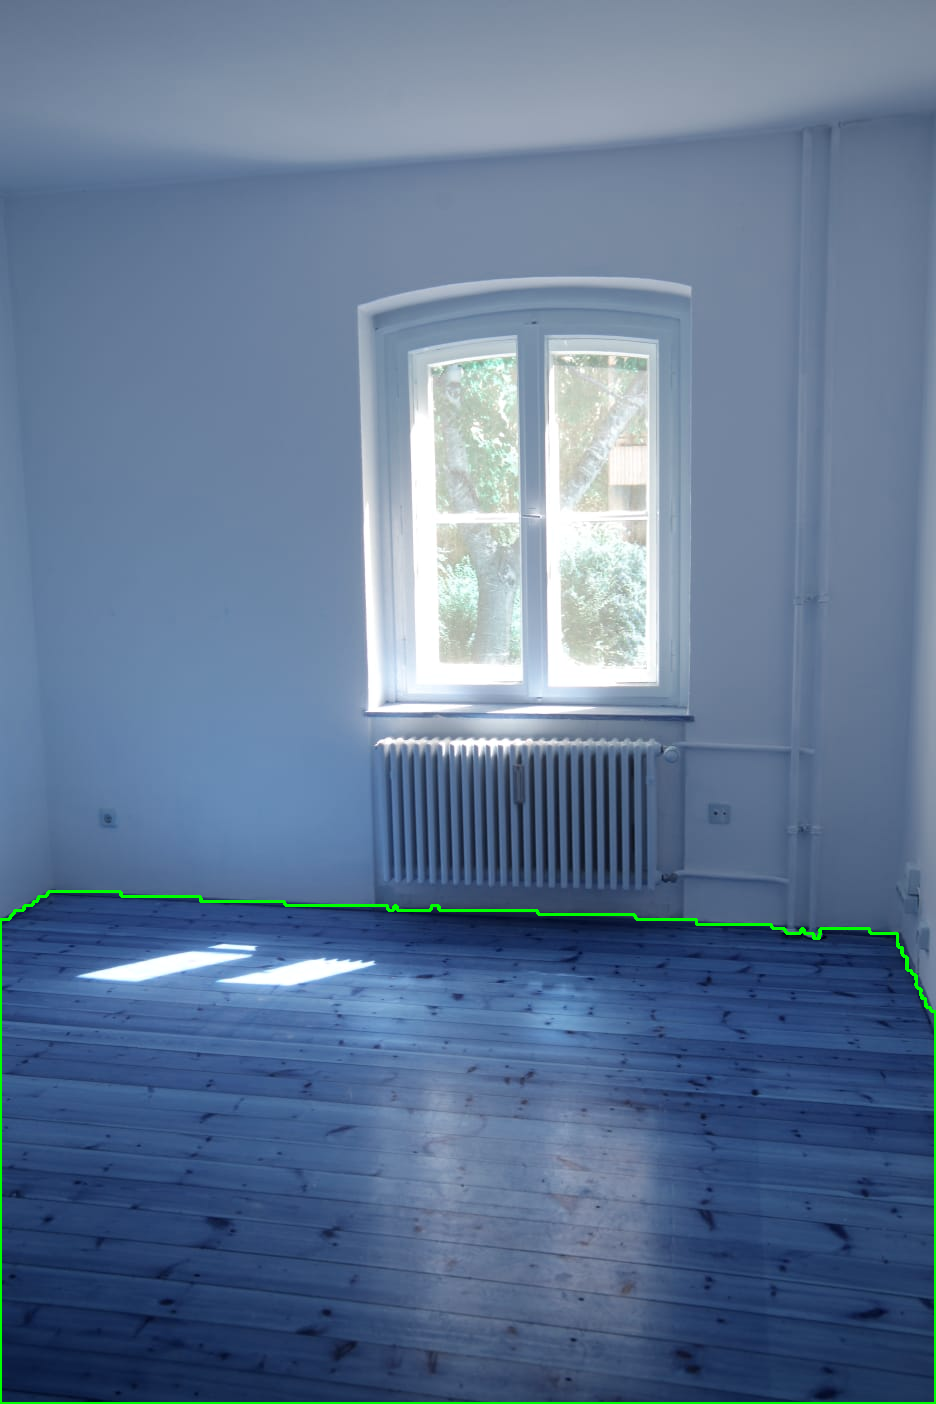

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(contour_image_floor)

In [ ]:
wall_contours, _ = cv2.findContours(mask_wall, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_wall_contour = max(wall_contours, key=cv2.contourArea)
contour_image_wall = image_np.copy()

cv2.drawContours(contour_image_wall, [largest_wall_contour], 0, (0, 255, 0), 2)
x, y, w, h = cv2.boundingRect(largest_wall_contour)
room_height = h
print("height of the room:", room_height, "pixels")

height of the room: 905 pixels


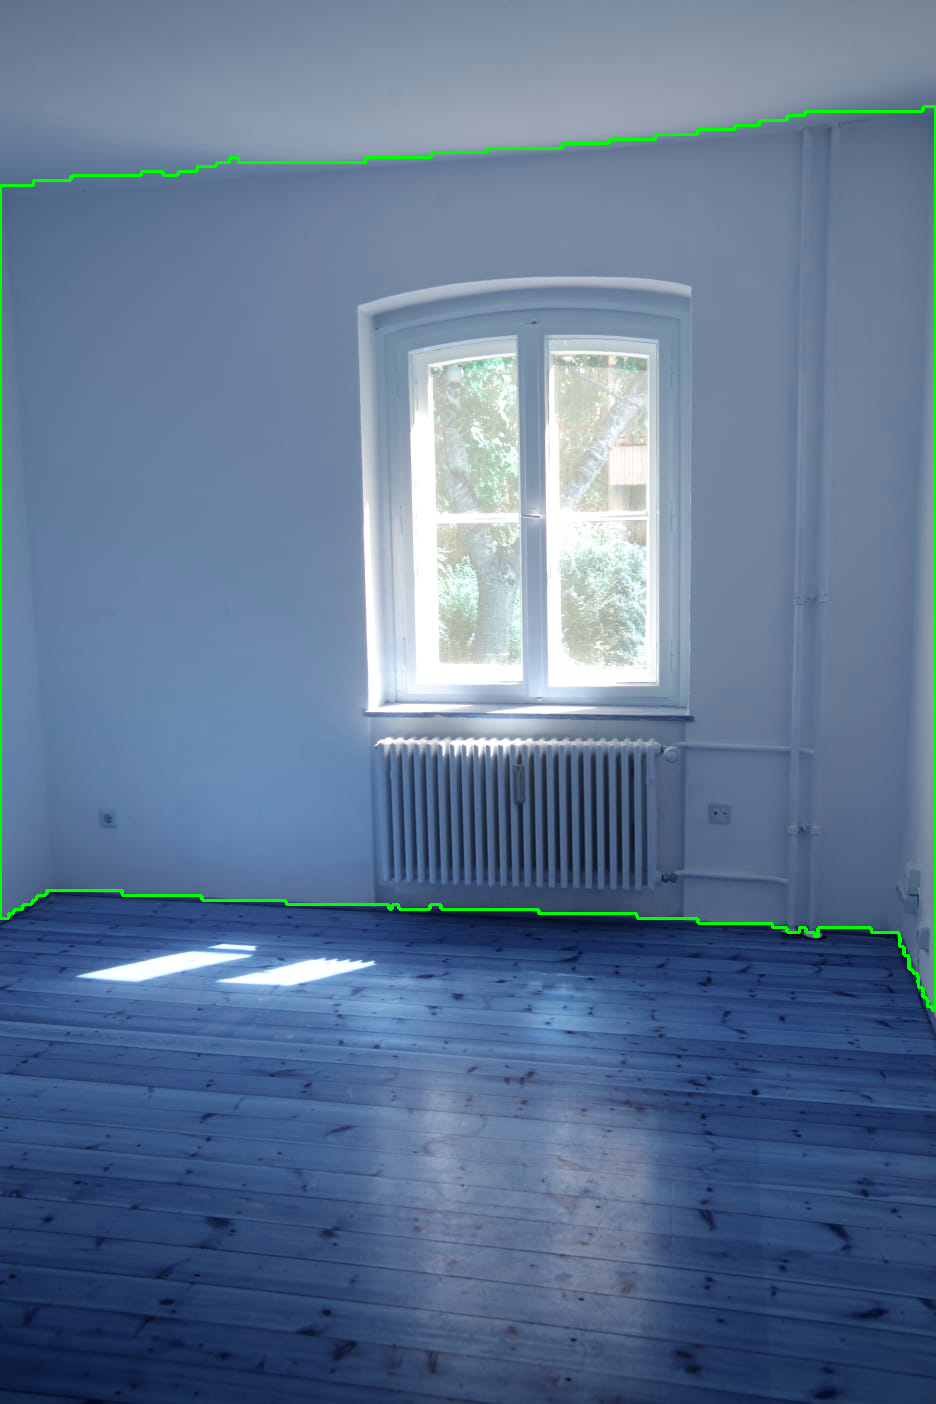

In [ ]:
cv2_imshow(contour_image_wall)

In [ ]:
window_contours, _ = cv2.findContours(mask_window, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_window_contour = max(window_contours, key=cv2.contourArea)
contour_image_window = image_np.copy()

cv2.drawContours(contour_image_window, [largest_window_contour], 0, (0, 255, 0), 2)
x, y, w, h = cv2.boundingRect(largest_window_contour)
window_width = w
print("Width of the window:", window_width, "pixels")

Width of the window: 337 pixels


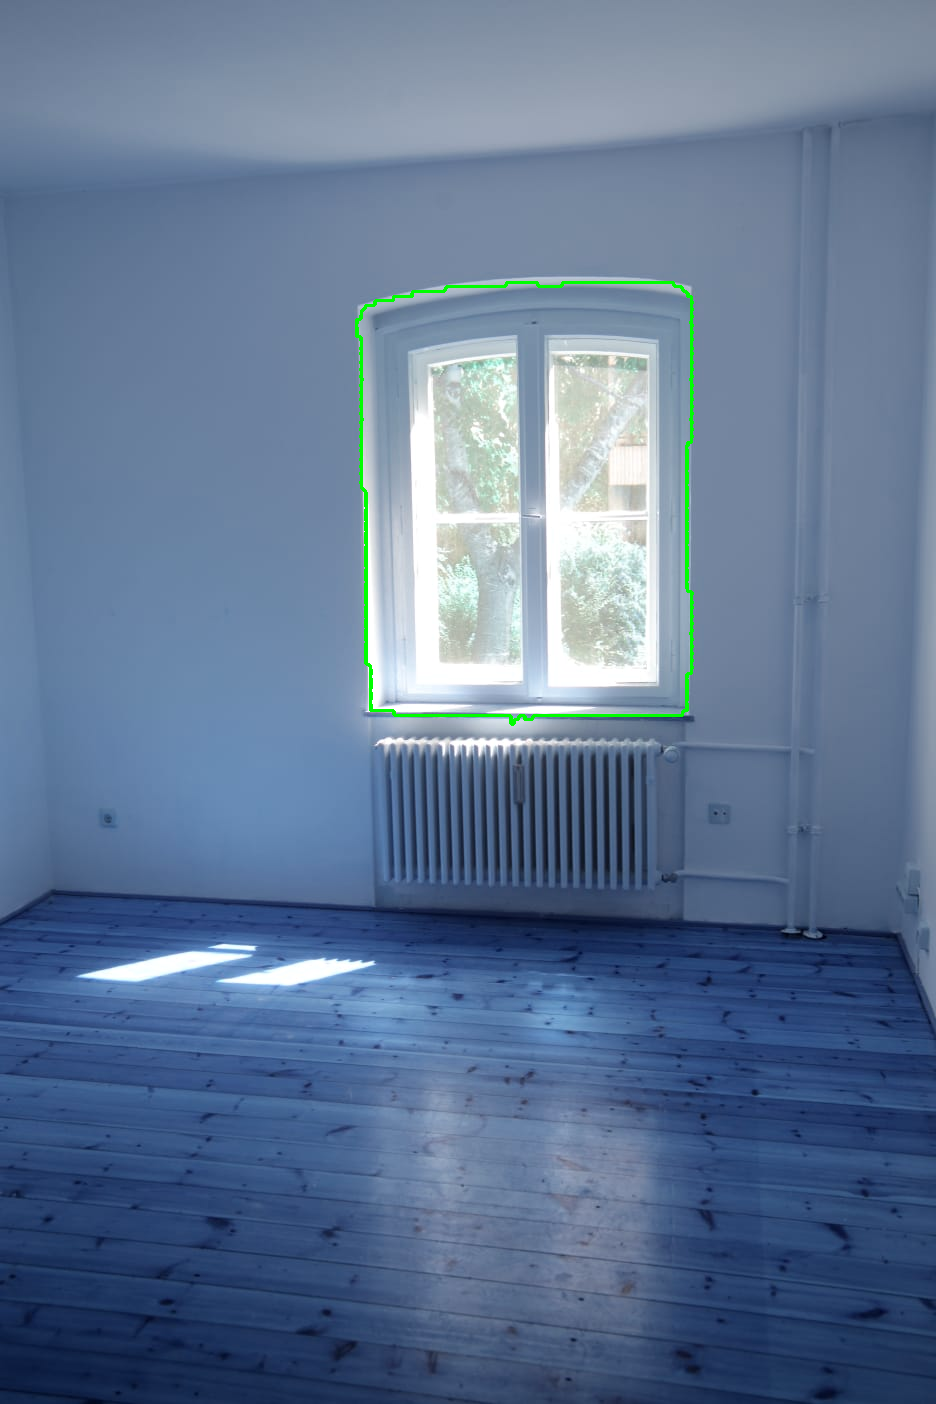

In [ ]:
cv2_imshow(contour_image_window)

Assuming width of the window is 140cm


In [ ]:
scaling_factor = 140/window_width
print("Sacling factor is", scaling_factor, "centimeter per pixel")

Sacling factor is 0.41543026706231456 centimeter per pixel


In [ ]:
room_width_in_meters = (room_width * scaling_factor)/100
print("The approximate width of the room is", room_width_in_meters, "meters")
room_height_in_meters = (room_height * scaling_factor)/100
print("The approximate height of the room is", room_height_in_meters, "meters")

The approximate width of the room is 3.8884272997032645 meters
The approximate height of the room is 3.7596439169139466 meters


## **Approximate width of the room is 3.88 meter (12.72 ft) and height is 3.75 meter (12.3 ft).**



